### In this file there are three models trained, each with different length of generated sequence

In [1]:
from imports import *

2024-06-27 12:54:14.899531: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 12:54:14.921654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 12:54:14.921675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 12:54:14.921692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 12:54:14.926016: I tensorflow/core/platform/cpu_feature_g

In [2]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
from load_data import DataLoader
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()
data_loader = DataLoader()

In [3]:
data, pip_factor= data_loader.load_eurusd_15min()

In [4]:
train_pct = 0.6
val_pct = 0.2

In [5]:
b, a = butter(5, 1/8, btype='low', analog=False)
data['bw_open'] = filtfilt(b, a, data['open'])
data['bw_high'] = filtfilt(b, a, data['high'])
data['bw_low'] = filtfilt(b, a, data['low'])
data['bw_close'] = filtfilt(b, a, data['close'])

In [6]:
data['rsi_close_7'] = abstract.RSI(data, timeperiod=7, price='bw_close')
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='bw_close')
data['willr_close_12'] = abstract.WILLR(data, timeperiod=12, price='bw_close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='bw_close')

In [7]:
data.dropna(how='any', axis=0, inplace=True)

In [8]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42', 'rsi_close_7', 'willr_close_12'])

In [9]:
target_time = data[['time', 'bw_close', 'close']]

In [10]:
data = data_processor.diff_features(data, ['close', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])

In [11]:
data.loc[:, 'close'] *= pip_factor
data.loc[:, 'bw_close'] *= pip_factor
data.loc[:, 'bw_open'] *= pip_factor
data.loc[:, 'bw_high'] *= pip_factor
data.loc[:, 'bw_low'] *= pip_factor

In [12]:
target = data[['close', 'bw_close']]

In [13]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

/tmp/ipykernel_38538/4177561520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)


In [14]:
input_seq_len = 64
output_seq_len_0 = 4  # 1 hour
output_seq_len_1 = 8  # 2 hours
output_seq_len_2 = 16  # 4 hours

## Forecast 8 time steps - 2 hours

In [15]:
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len_1,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': 1,
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [16]:
Xdata_1, ydata_1 = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len_1)

In [17]:
np.random.seed(42)
shuffled_indices_1 = np.random.permutation(Xdata_1.shape[0])
Xdata_1 = Xdata_1[shuffled_indices_1]
ydata_1 = ydata_1[shuffled_indices_1]

In [18]:
Xtrain_time_1, ytrain_c_1, Xval_time_1, yval_c_1, Xtest_time_1, ytest_c_1 = model_trainer.split_data(Xdata_1, ydata_1, train_pct, val_pct)

In [19]:
Xtrain_1 = (Xtrain_time_1[:, :, 1:]).astype(np.float64)
Xval_1 = (Xval_time_1[:, :, 1:]).astype(np.float64)
Xtest_1 = (Xtest_time_1[:, :, 1:]).astype(np.float64)

ytrain_1 = ytrain_c_1[:, :, 1:]
yval_1 = yval_c_1[:, :, 1:]
ytest_1 = ytest_c_1[:, :, 1:]

In [20]:
path_1 = 'saved_models/tf-15m-64in-8out.h5'

In [21]:
model_1 = model_trainer.load_model_transformer(path_1, Xtest_1, config)

2024-06-27 12:46:50.752715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9575 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [22]:
with tf.device('/CPU:0'):
    pred_1 = model_1(Xtest_1, target=None, training=False)

In [23]:
real_price_movement_1 = list(data_processor.sum_along_seq_dim(ytest_c_1[:,:,0]))
pred_price_movement_1 = list(data_processor.sum_along_seq_dim(pred_1[:,:,0]))

In [24]:
real_classes_1 = data_processor.create_binary_classification_classes(real_price_movement_1, 0.0)
pred_classes_1 = data_processor.create_binary_classification_classes(pred_price_movement_1, 0.0)

In [25]:
accuracy_0_1, precision_0_1, recall_0_1, f1_0_1 = data_processor.create_metrics_from_classes_binary(real_classes_1, pred_classes_1)
visualizer.create_metrics_df(accuracy_0_1, precision_0_1, recall_0_1, f1_0_1)

,Metric,Value
0,Accuracy,0.755731
1,Precision,0.785683
2,Recall,0.715914
3,F1 Score,0.749178


In [26]:
real_price_movement = list(data_processor.sum_along_seq_dim(ytest_c_1[:,:,0]))
pred_price_movement = list(data_processor.sum_along_seq_dim(pred_1[:,:,0]))

In [27]:
#real_classes, pred_classes = create_classification_classes(real_price_movement, pred_price_movement)
real_classes = data_processor.create_binary_classification_classes(real_price_movement, 0.0)
pred_classes = data_processor.create_binary_classification_classes(pred_price_movement, 0.0)

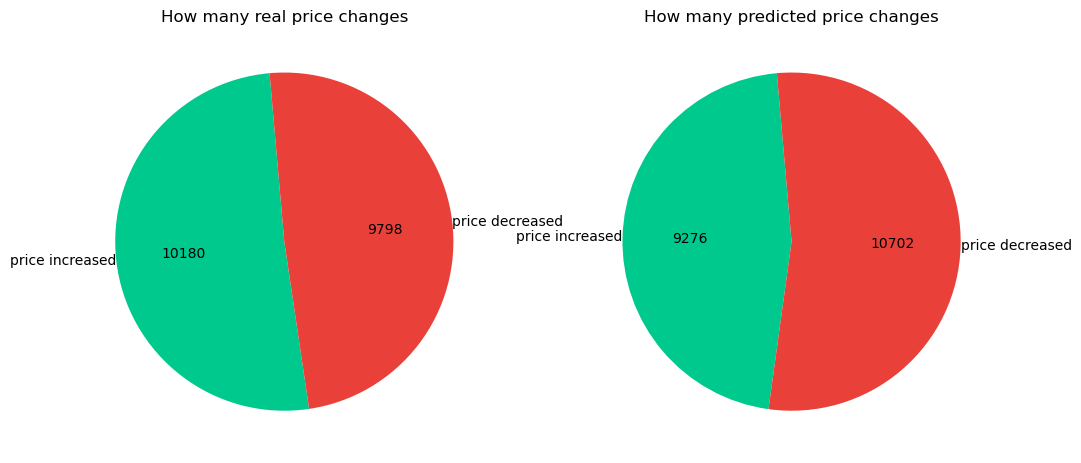

In [28]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)

In [29]:
real_price_movement_pct = data_processor.find_pct_movements(Xtest_time_1, target_time, real_price_movement, pip_factor)
pred_price_movement_pct = data_processor.find_pct_movements(Xtest_time_1, target_time, pred_price_movement, pip_factor)

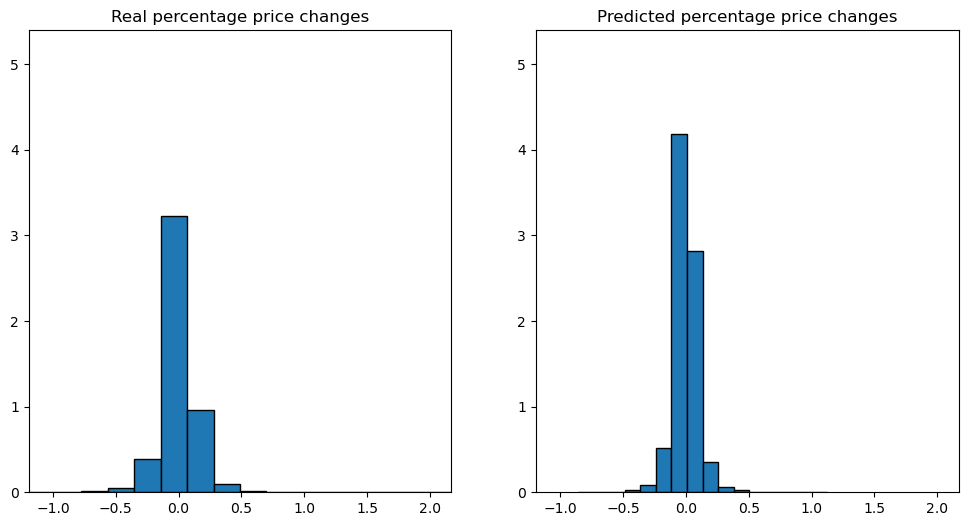

In [30]:
visualizer.plot_two_histograms(real_price_movement_pct, pred_price_movement_pct)

In [31]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")

accuracies_ternary = []
precisions_ternary = []
recalls_ternary = []
f1s_ternary = []

accuracies_binary = []
precisions_binary = []
recalls_binary = []
f1s_binary = []

start = 0
end = 1
thresholds = np.linspace(start, end, 100)

for threshold in thresholds:  # threshold == 1 means one percent change in price
    real_ternary_classes = data_processor.create_ternary_classification_classes(real_price_movement_pct, threshold, 0.0)
    pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_price_movement_pct, threshold, 0.0)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_ternary(real_ternary_classes, pred_ternary_classes)
    accuracies_ternary.append(accuracy)
    precisions_ternary.append(precision)
    recalls_ternary.append(recall)
    f1s_ternary.append(f1)

    real_price_movement_pct_reduced, pred_price_movement_pct_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement_pct, pred_price_movement_pct)
    real_tmp = data_processor.create_binary_classification_classes(real_price_movement_pct_reduced, 0.0)
    pred_tmp = data_processor.create_binary_classification_classes(pred_price_movement_pct_reduced, 0.0)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
    accuracies_binary.append(accuracy)
    precisions_binary.append(precision)
    recalls_binary.append(recall)
    f1s_binary.append(f1)

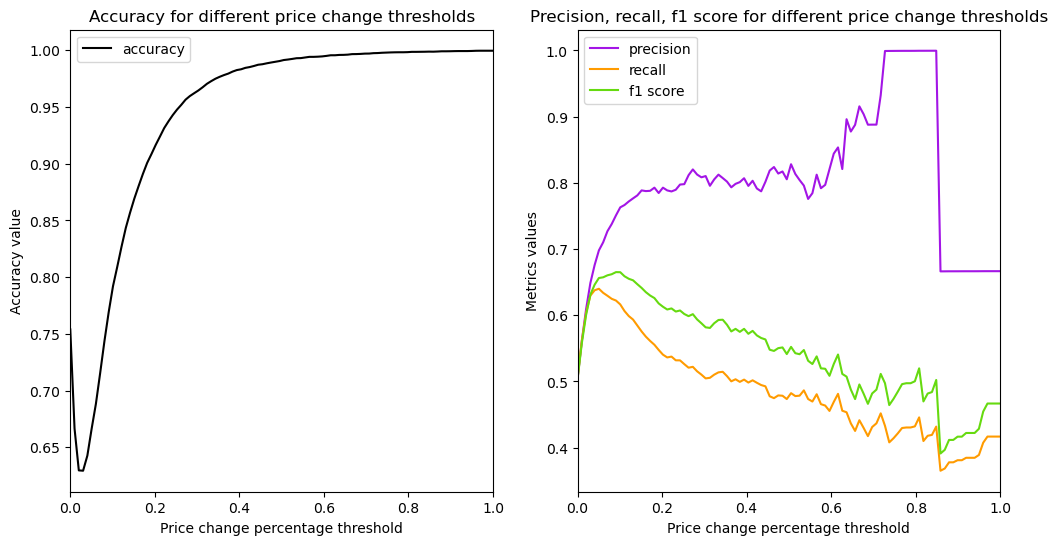

In [32]:
visualizer.plot_metrics_ternary(thresholds, accuracies_ternary, precisions_ternary, recalls_ternary, f1s_ternary)

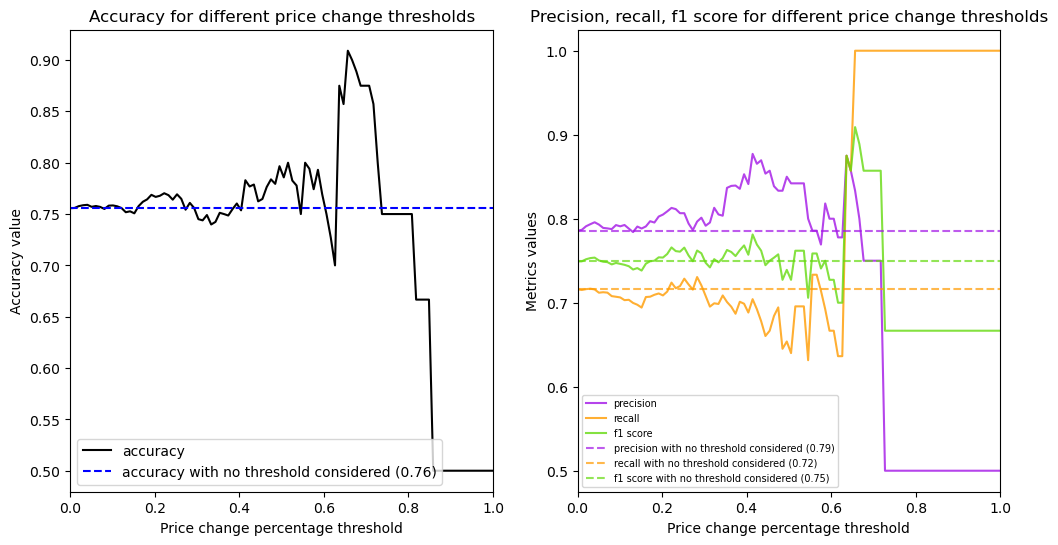

In [33]:
visualizer.plot_metrics_binary(thresholds, accuracies_binary, precisions_binary, recalls_binary, f1s_binary, accuracy_0_1, precision_0_1, recall_0_1, f1_0_1, "lower left", "lower left")

## Forecast 4 time steps - 1 hour

In [ ]:
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len_0,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': 1,
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [16]:
Xdata_0, ydata_0 = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len_0)

In [17]:
np.random.seed(42)
shuffled_indices_0 = np.random.permutation(Xdata_0.shape[0])
Xdata_0 = Xdata_0[shuffled_indices_0]
ydata_0 = ydata_0[shuffled_indices_0]

In [18]:
Xtrain_time_0, ytrain_c_0, Xval_time_0, yval_c_0, Xtest_time_0, ytest_c_0 = model_trainer.split_data(Xdata_0, ydata_0, train_pct, val_pct)

In [19]:
Xtrain_0 = (Xtrain_time_0[:, :, 1:]).astype(np.float64)
Xval_0 = (Xval_time_0[:, :, 1:]).astype(np.float64)
Xtest_0 = (Xtest_time_0[:, :, 1:]).astype(np.float64)

ytrain_0 = ytrain_c_0[:, :, 1:]
yval_0 = yval_c_0[:, :, 1:]
ytest_0 = ytest_c_0[:, :, 1:]

In [20]:
epochs = 15

path_0 = 'saved_models/tf-15m-64in-4out.h5'

model_0 = model_trainer.load_model_transformer(path_0, Xtest_0, config)

#model = Transformer(config)

2024-06-27 12:43:18.021275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [21]:
#model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

In [22]:
with tf.device('/CPU:0'):
    pred_0 = model_0(Xtest_0, target=None, training=False)

In [23]:
real_price_movement_0 = list(data_processor.sum_along_seq_dim(ytest_c_0[:,:,0]))
pred_price_movement_0 = list(data_processor.sum_along_seq_dim(pred_0[:,:,0]))

In [24]:
#real_classes, pred_classes = create_classification_classes(real_price_movement, pred_price_movement)
real_classes_0 = data_processor.create_binary_classification_classes(real_price_movement_0, 0.0)
pred_classes_0 = data_processor.create_binary_classification_classes(pred_price_movement_0, 0.0)

In [25]:
accuracy_0_0, precision_0_0, recall_0_0, f1_0_0 = data_processor.create_metrics_from_classes_binary(real_classes_0, pred_classes_0)
visualizer.create_metrics_df(accuracy_0_0, precision_0_0, recall_0_0, f1_0_0)

,Metric,Value
0,Accuracy,0.713084
1,Precision,0.732464
2,Recall,0.695194
3,F1 Score,0.713343


## Forecast 16 time steps - 4 hours

In [15]:
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len_2,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': 1,
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [16]:
Xdata_2, ydata_2 = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len_2)

In [17]:
np.random.seed(42)
shuffled_indices_2 = np.random.permutation(Xdata_2.shape[0])
Xdata_2 = Xdata_2[shuffled_indices_2]
ydata_2 = ydata_2[shuffled_indices_2]

In [18]:
Xtrain_time_2, ytrain_c_2, Xval_time_2, yval_c_2, Xtest_time_2, ytest_c_2 = model_trainer.split_data(Xdata_2, ydata_2, train_pct, val_pct)

In [19]:
Xtrain_2 = (Xtrain_time_2[:, :, 1:]).astype(np.float64)
Xval_2 = (Xval_time_2[:, :, 1:]).astype(np.float64)
Xtest_2 = (Xtest_time_2[:, :, 1:]).astype(np.float64)

ytrain_2 = ytrain_c_2[:, :, 1:]
yval_2 = yval_c_2[:, :, 1:]
ytest_2 = ytest_c_2[:, :, 1:]

In [20]:
path_2 = 'saved_models/tf-15m-64in-16out.h5'

In [21]:
model_2 = model_trainer.load_model_transformer(path_2, Xtest_2, config)

2024-06-27 12:54:41.584952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9562 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [22]:
with tf.device('/CPU:0'):
    pred_2 = model_2(Xtest_2, target=None, training=False)

In [23]:
real_price_movement_2 = list(data_processor.sum_along_seq_dim(ytest_c_2[:,:,0]))
pred_price_movement_2 = list(data_processor.sum_along_seq_dim(pred_2[:,:,0]))

In [24]:
real_classes_2 = data_processor.create_binary_classification_classes(real_price_movement_2, 0.0)
pred_classes_2 = data_processor.create_binary_classification_classes(pred_price_movement_2, 0.0)

In [25]:
accuracy_0_2, precision_0_2, recall_0_2, f1_0_2 = data_processor.create_metrics_from_classes_binary(real_classes_2, pred_classes_2)
visualizer.create_metrics_df(accuracy_0_2, precision_0_2, recall_0_2, f1_0_2)

,Metric,Value
0,Accuracy,0.576342
1,Precision,0.727532
2,Recall,0.274205
3,F1 Score,0.398294
